# Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
# import luigi
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression, Ridge, Lasso
import xgboost as xgb, catboost as catb, lightgbm as lgbm

from matplotlib import pyplot as plt
from datetime import datetime
from dask import dataframe as dd
from pathlib import Path

from tqdm import tqdm

from dask.distributed import Client, LocalCluster

cluster = LocalCluster()
client = Client(cluster)

# Пути к директориям и файлам 

In [2]:
DATA_ROOT = Path('E:/2. УЧЕБА ЭНИ')
FEATURES = DATA_ROOT / 'features.csv'
TRAIN = DATA_ROOT / 'data_train.csv'
TEST = DATA_ROOT / 'data_test.csv'

# Постановка задачи

## Цель

Необходимо построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

## Целевая переменная

target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно

## Метрика качества

$$f_1=\frac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} \cdot \text{recall}}$$

## Требования к решению

Метрика f1 должна быть больше 0.68 

## Описание датасета

Данные распределены между тремя файлами features.csv, data_train.csv, data_test.csv. features.csv - содержит значение фитчей в разные моменты времени. data_train содержит данные о факте отклика на предложение и время совершения транзакции

Колонки data_train.csv:
* **buy_time** - время покупки, представлено в формате timestamp
* **id** - идентификатор абонента
* **vas_id** - подключаемая услуга

Колонки features.csv:
* **buy_time** - время покупки, представлено в формате timestamp
* **id** - идентификатор абонента
* **0-252** - фитчи


# Загрузка данных 

if for_reload_all:
    train_df = pd.read_csv(TRAIN, index_col=0)
    test_df = pd.read_csv(TEST, index_col=0)
    features_ddf = dd.read_csv(FEATURES, sep='\t')
    features_ddf = features_ddf.drop(columns=['Unnamed: 0'])

if for_reload_all:
    train_df.head(2)

if for_reload_all:
    test_df.head(2)

if for_reload_all:
    features_ddf.head(2)

 # Преобразование данных, добавление фитчей

In [3]:
#TODO: оформить через liuigi

## Преобразование buy_time в datatime

if for_reload_all:
    TIME_COLUMNS = ['buy_time']

if for_reload_all:
    train_df.buy_time = train_df.buy_time.apply(lambda x: datetime.fromtimestamp(x))
    test_df.buy_time = test_df.buy_time.apply(lambda x: datetime.fromtimestamp(x))
    features_ddf.buy_time = features_ddf.buy_time.apply(lambda x: datetime.fromtimestamp(x), meta=('buy_time'))

if for_reload_all:
    test_df.head()

## Добавление фитчей

In [ ]:
train_merge_df = pd.merge_asof(left=train_df.sort_values(by='buy_time', ascending=True),
                               right=features_ddf.sort_values(
    by='buy_time', ascending=True).compute(),
    by=['id'],
    on=['buy_time'],
    direction='nearest'
)

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [ ]:
columns_list = train_merge_df.columns.tolist()
columns_list.remove('buy_time')
train_merge_df[columns_list] = reduce_mem_usage(train_merge_df[columns_list])

In [ ]:
train_merge_df.to_csv('~/Desktop/train_merge.csv')

In [ ]:
train_merge_df

In [ ]:
test_merge_df = pd.merge_asof(left=test_df.sort_values(by='buy_time', ascending=True),
                              right=features_ddf.sort_values(
    by='buy_time', ascending=True).compute(),
    by=['id'],
    on=['buy_time'],
    direction='nearest'
)

# Обозначение констант

In [2]:
TARGET_COLUMN_NAME = 'target'
RANDOM_STATE = 42

# Определение типа признаков

In [53]:
data_train_merge = dd.read_csv('~/Desktop/train_merge.csv')
data_train_merge = data_train_merge.set_index('Unnamed: 0')

# data_train_merge = pd.read_csv('~/Desktop/train_merge.csv', index_col=0)

# data_train_merge = pd.read_csv('~/Documents/ML/Megafon/Course project/Data/train_merge.csv', index_col=0)

In [10]:
# columns_list = data_train_merge.columns.tolist()
# columns_list.remove('buy_time')
# data_train_merge[columns_list] = reduce_mem_usage(data_train_merge[columns_list])

In [4]:
data_train_merge.buy_time = dd.to_datetime(data_train_merge.buy_time)
data_train_merge.dtypes

id                   int64
vas_id             float64
buy_time    datetime64[ns]
target             float64
0                  float64
                 ...      
248                float64
249                float64
250                float64
251                float64
252                float64
Length: 257, dtype: object

In [9]:
data_train_merge_nunique = pd.Series(dtype='float32')


for column in tqdm(data_train_merge.columns.to_list()):
#     data_train_merge_nunique[column] = data_train_merge[column].nunique().compute()
    data_train_merge_nunique[column] = data_train_merge[column].nunique()

100%|████████████████████████████████████████████████████████████████████████████████| 257/257 [00:04<00:00, 62.79it/s]


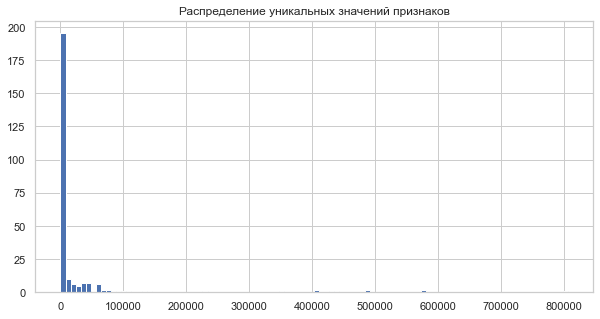

In [10]:
plt.title("Распределение уникальных значений признаков");
data_train_merge_nunique.hist(bins=100, figsize=(10, 5));

In [10]:
ALL_FEATURES = set(data_train_merge_nunique.index.tolist())
len(ALL_FEATURES)

257

## Константные признаки

In [11]:
CONST_FEATURES = set(data_train_merge_nunique[data_train_merge_nunique == 1].index.tolist())
len(CONST_FEATURES)

5

## Вещественные признаки

In [13]:
NUMERIC_FEATURES = (data_train_merge.drop('buy_time', axis=1).astype(int).sum() - data_train_merge.drop('buy_time', axis=1).sum()).abs()
NUMERIC_FEATURES = set(NUMERIC_FEATURES[NUMERIC_FEATURES > 0].index.tolist())
len(NUMERIC_FEATURES)

244

## Бинарные признаки

In [14]:
f_other = ALL_FEATURES - (NUMERIC_FEATURES | CONST_FEATURES)
len(f_other)

8

In [15]:
BINARY_FEATURES = set(data_train_merge.loc[:, f_other].columns[(
    (data_train_merge.loc[:, f_other].max() == 1) & \
    (data_train_merge.loc[:, f_other].min() == 0)
)])

len(BINARY_FEATURES), print(BINARY_FEATURES)

{'target'}


(1, None)

In [16]:
f_other = f_other - BINARY_FEATURES
len(f_other)

7

## Категориальные

In [17]:
CATEGORIES_FEATURES = set(data_train_merge_nunique.loc[f_other][data_train_merge_nunique.loc[f_other] <= 10].index.tolist())
print(CATEGORIES_FEATURES)

{'vas_id'}


In [18]:
f_other = f_other - CATEGORIES_FEATURES

## Признаки которые нас не интересуют 

In [19]:
DOESNT_INTERESTING_FEATURES = set(['buy_time', 'id'])

In [20]:
f_other = f_other - DOESNT_INTERESTING_FEATURES
f_other

{'222', '224', '225', '252'}

In [22]:
data_train_merge['222'].unique()

array([ 9.7249730e+08,  9.6489410e+08,  9.6299330e+08,  9.6619010e+08,
        9.7344770e+08, -5.7266950e+08,  9.6031490e+08,  9.6135170e+08,
        9.5996930e+08,  9.7526210e+08,  9.6955970e+08,  9.6826370e+08,
        9.6800450e+08,  9.5893250e+08,  9.7085570e+08,  9.7059650e+08,
        9.6739970e+08,  9.7508930e+08,  9.7171970e+08,  9.6981890e+08,
        9.7353410e+08,  9.6264770e+08,  9.5953730e+08,  9.7042370e+08,
        9.7362050e+08,  9.6195650e+08,  9.7310210e+08,  9.7284290e+08,
        9.6973250e+08,  9.6921410e+08,  9.6126530e+08,  9.7206530e+08,
        9.6696770e+08,  9.7163330e+08,  9.6307970e+08,  9.6515330e+08,
        9.6878210e+08,  9.7137410e+08,  9.7465730e+08,  9.7405250e+08,
        9.6342530e+08,  9.6765890e+08,  9.5841410e+08,  9.6091970e+08,
        9.6014210e+08,  9.7267010e+08,  9.6437570e+08,  9.6333890e+08,
        9.6558530e+08,  9.7223810e+08,  9.6843650e+08,  9.6498050e+08,
        9.7327490e+08,  9.6368450e+08,  9.7586690e+08,  9.7215170e+08,
      

In [23]:
NUMERIC_FEATURES = NUMERIC_FEATURES | f_other

In [24]:
f_other = f_other - NUMERIC_FEATURES
len(f_other)

0

In [25]:
data_train_merge_nunique.shape[0] == len(CONST_FEATURES) + len(BINARY_FEATURES) + len(NUMERIC_FEATURES) + len(CATEGORIES_FEATURES) + len(DOESNT_INTERESTING_FEATURES)

True

# EDA

In [27]:
# пропусков нет
data_train_merge.isna().sum().sum()

0

## Распределение данныех на train и test

In [ ]:
# TODO: проверить распределение на train и test

## Корреляции признаков с целевой переменной

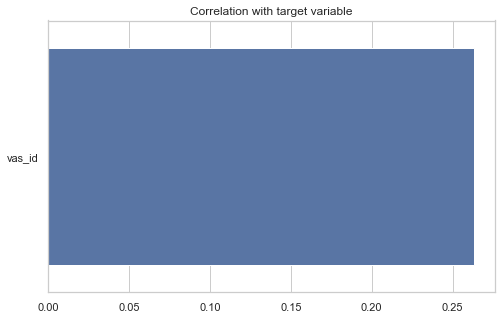

In [28]:
corr_with_target = data_train_merge[list(ALL_FEATURES - DOESNT_INTERESTING_FEATURES)].corr(
)[TARGET_COLUMN_NAME].drop(TARGET_COLUMN_NAME).sort_values(ascending=False)

plt.figure(figsize=(8, 5))

# выберим признаки со значительной линейной коррелицией
mask = (corr_with_target > 0.2) | (corr_with_target < -0.2)
sns.barplot(x=corr_with_target[mask].values,
            y=corr_with_target[mask].index)

plt.title('Correlation with target variable')
plt.show()

#### Вывод: Данные практически не коллерируют с таргетом

## Целевая переменная 

Количество позитивных меток = 60186.0
Количество негативных меток = 771467.0
Коэффициент равномерности распределения данных = 0.07236912510385943


<AxesSubplot:>

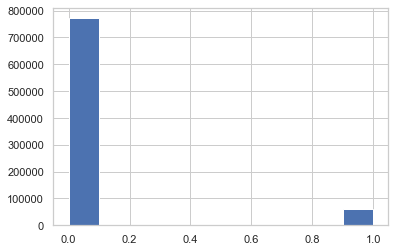

In [29]:
ones_count = data_train_merge[TARGET_COLUMN_NAME].sum()
total_count = data_train_merge[TARGET_COLUMN_NAME].shape[0]
zeros_count = total_count - ones_count

print('Количество позитивных меток = {}'.format(ones_count))
print('Количество негативных меток = {}'.format(zeros_count))
print('Коэффициент равномерности распределения данных = {}'.format(
    ones_count / total_count))

data_train_merge[TARGET_COLUMN_NAME].hist()

#### Вывод: Данные неравномерны 

## Количественные переменные

In [30]:
data_train_merge[list(NUMERIC_FEATURES)].describe()

,14,172,187,104,190,132,24,79,112,122,...,57,108,88,134,73,107,21,206,93,8
count,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,...,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000,831653.000000
mean,0.055042,-0.063296,-0.018855,0.002198,0.007657,-0.001624,0.000971,0.174142,-1.960443,0.001461,...,-0.000023,0.086706,0.019510,0.156421,0.012164,0.002970,0.124591,0.000063,-0.005159,0.054181
std,159.586531,58.200941,24.724434,15.074610,4.721688,0.498898,2.753164,234.691389,3871.577275,4.263701,...,0.040376,47.476393,14.248820,578.874770,57.455553,6.971093,67.118778,0.094760,12.284336,116.690843
min,-1132.608200,-30.821720,-16.354809,-3.447583,-0.163184,-0.468443,-0.009327,-0.998268,-1187.961700,-0.024048,...,-0.001656,-11.955315,-0.096986,-197.670380,-5.390212,-0.212137,-536.164200,-0.008999,-0.185299,-389.723660
25%,-77.518110,-30.621720,-15.354808,-3.447583,-0.163184,-0.468443,-0.009327,-0.998268,-1187.961700,-0.024048,...,-0.001656,-11.955315,-0.096986,-190.670380,-5.390212,-0.212137,-10.744164,-0.008999,-0.185299,-6.783660
50%,-77.518110,-20.888388,-8.354808,-3.447583,-0.163184,-0.468443,-0.009327,-0.998268,-1092.617000,-0.024048,...,-0.001656,-11.955315,-0.096986,-190.670380,-5.390212,-0.212137,-10.744164,-0.008999,-0.185299,-6.783660
75%,-0.878110,6.128281,5.645192,-1.757583,-0.163184,0.531558,-0.009327,-0.998268,-405.093570,-0.024048,...,-0.001656,-8.955315,-0.096986,-190.670380,-5.390212,-0.212137,-10.744164,-0.008999,-0.185299,-6.783660
max,5351.812000,4270.478500,1776.645100,2156.832500,968.403440,0.531558,2142.020800,211826.520000,495434.900000,2246.615500,...,0.998344,5440.724600,6560.973000,5046.329600,28373.230000,2211.638000,7372.285600,0.991001,5399.824700,88528.340000


In [43]:
def print_report(df: pd.DataFrame or dd.DataFrame, 
                 columns_list: list,  
                 quantile: int = .95):
    """
    Report is printed for numeric data
    
    Input
    -----
        df: input dataframe witch can be pandas.DataFrame or dask.DataFrame
        columns_list: lins of numerc columns
        quantile: quntile for select columns with outliners
        
    Return
    ------
        is_cat_features and columns_with_outliners. is_cat_features dict with columns name and count
        of unique values. columns_with_outliners is list with columns name with values contains 
        outliners
        
    """
    
    is_cat_features = dict()
    columns_with_outliners = list()
    
    is_dask_datafram = False
    if isinstance(df, dd.DataFrame):
        is_dask_datafram = True
    
    for column in tqdm(columns_list):
#         print('-' * 50)
#         print(' ' * 20, column)
#         print('-' * 50)
        
        nunique_values = df[column].nunique().compute() if is_dask_datafram else df[column].nunique()
        
        # calc category features
        if nunique_values < 5:
#             print('Unique values is ', df[column].unique().compute if is_dask_datafram else df[column].unique()) 
            is_cat_features[column] = nunique_values
            
        column_values = df[column].compute() if is_dask_datafram else df[column]
        q = column_values.quantile(q=quantile)
#         print('99 quantile is', q)
        
        # calc count of features with outliners 
        if column_values.max() > q * 1.5:
            columns_with_outliners.append(column)
        
#         fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
#         ax1.set_title('Box plots')
#         ax2.set_title('Distribution')
#         sns.boxenplot(x=column_values, ax=ax1)
#         sns.histplot(x=column_values, ax=ax2)
#         ax2.axvline(x=q, c='r')
#         ax1.axvline(x=q, c='r')
#         plt.show()
        
    return is_cat_features, columns_with_outliners

is_cat_features, columns_with_outliners = print_report(df=data_train_merge, columns_list=list(NUMERIC_FEATURES))


100%|████████████████████████████████████████████████████████████████████████████████| 248/248 [00:06<00:00, 39.16it/s]


**Выводы:** большое количество выбросов, их нужно обработать

## Категориальные признаки

In [44]:
def get_confidence_intervals(x: str, y: str, df_x_y: pd.DataFrame):
    """
    Функция для построение доверительных интервалов
    
    Parametrs
    ---------
        y: значение по оси y
        df_x_y: датафрейм с данными
        x: значение по оси x
    
    Return
    ------
        None
    
    How to use
    ----------
        get_confidence_intervals('column_1', 'tatget', df[['column_1', 'target']])
    """

    plt.figure(figsize=(8, 5))

    sns.pointplot(x=x, y=y, data=df_x_y, capsize=.1)

    plt.title(f'Confidence intervals (95 %) for {y}')
    plt.show()

Проверим, является ли предпологаемые значения категориальными фитчами используя весь dataset features

In [45]:
cat_features = dict()

for column in tqdm(is_cat_features):
    cat_features[column] = features_ddf[column].nunique().compute()
    

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]


NameError: name 'features_ddf' is not defined

In [ ]:
cat_features

In [ ]:
cat_features.pop('95')

In [46]:
is_cat_features.pop('95')

CATEGORIES_FEATURES = CATEGORIES_FEATURES | set(is_cat_features.keys())
NUMERIC_FEATURES = NUMERIC_FEATURES - set(is_cat_features.keys())

  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

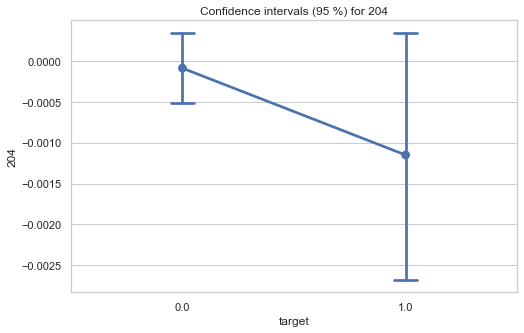

  5%|███▉                                                                               | 1/21 [00:32<10:42, 32.12s/it]


KeyboardInterrupt: 

<Figure size 576x360 with 0 Axes>

In [47]:
for column in tqdm(list(CATEGORIES_FEATURES)):
    get_confidence_intervals(y=column, x=TARGET_COLUMN_NAME, df_x_y=data_train_merge)

#### Вывод: признаки 197, 33, 27, 202, 32, 26, 132, 206 - претиденты на выброс, т.к. одинаково влияет на целевую переменную

# Обработка выбросов

In [ ]:
# ! BaseLine - не будем обрабатывать выбросы

# Обработка пропусков

In [ ]:
# ! BaseLine - пропусков нет

# Сокращение размерности 

In [ ]:
CONST_FEATURES

Проверим на всем ли датасете features эти колонки имеют одоно и тоже значение

In [ ]:
unique_dict = dict()

for column in tqdm(list(CONST_FEATURES)):
    unique_dict[column] = features_ddf[column].nunique().compute()

In [ ]:
unique_dict

In [73]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
#         assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame не содердит следующие колонки: %s" % cols_error)

In [69]:
class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns) -> None:
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
#         if not isinstance(X, pd.DataFrame):
#             raise TypeError('Input data must be pd.DataFrame')
        
        try:
            return X.drop(columns=self.columns)
            
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("DataFrame doesn't contain this coluumn name: %s" % cols_error)

In [ ]:
# ! BaseLinе - остальные признаки удалять не будем

In [71]:
if 'id' in DOESNT_INTERESTING_FEATURES:
    DOESNT_INTERESTING_FEATURES.remove('id')

drop_unusefull_features = Pipeline([
    ('drop_const_feat', DropColumns(
        columns=list(CONST_FEATURES.union(set(['id'])))
    ))
])

drop_unusefull_features.fit_transform(data_train_merge).shape

(Delayed('int-24b2f02e-1324-4ae4-b30c-f4748e643ac8'), 251)

data_train_merge.shape

# Построение новых признаков

In [ ]:
# BaseLine - без новых признков (stupid gen)

## Категориальные признаки

In [143]:
class SetCategoryType(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.type_name = 'category'
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.astype(self.type_name).categorize(columns=list(CATEGORIES_FEATURES))

In [144]:
from dask_ml.preprocessing import OneHotEncoder

handler_category_features = Pipeline([
    ('select_cat_features', ColumnSelector(columns=list(CATEGORIES_FEATURES))),
    ('set_category_types', SetCategoryType()),
    ('one_hot_encode', OneHotEncoder())
])

handler_category_features.fit_transform(X=data_train_merge).shape

KeyboardInterrupt: 

# Маштабирование признаков

In [107]:
from dask_ml.preprocessing import StandardScaler

handler_numeric_features = Pipeline([
    ('select_numeric_features', ColumnSelector(columns=list(NUMERIC_FEATURES))),
    ('standart_scaller', StandardScaler())
])

handler_numeric_features.fit_transform(data_train_merge).head(2)

,14,172,187,104,190,24,79,112,122,44,...,101,220,108,88,134,73,107,21,93,8
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,2.062875,-0.513596,-0.377601,0.074975,-0.036182,-0.00374,-0.004996,-0.085194,-0.005983,0.059024,...,-0.077351,-0.002083,-0.253642,-0.008176,-0.329651,-0.094027,-0.030857,-0.161933,-0.014664,-0.058598
1,0.708750,0.261879,0.026858,-0.228847,-0.036182,-0.00374,-0.004996,-0.306336,-0.005983,-0.032907,...,-0.077351,-0.002083,-0.253642,-0.008176,-0.329651,-0.094027,-0.030857,-0.161933,-0.014664,-0.058598


# Pipeline обработки признаков

In [142]:
feature_preprocessing = Pipeline([
    ('feature_preprocessing', FeatureUnion(transformer_list=[
        ('drop_unusefull_features', drop_unusefull_features),
        ('handler_category_features', handler_category_features),
        ('handler_numeric_features', handler_numeric_features)
    ]))
])

handler_category_features.fit_transform(X_train)

KeyboardInterrupt: 

# Разбиение на train и test

In [110]:
from dask_ml.model_selection import train_test_split

X = data_train_merge.drop(TARGET_COLUMN_NAME, axis=1)
y = data_train_merge[TARGET_COLUMN_NAME]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    shuffle=True,
    test_size=0.3,
    random_state=RANDOM_STATE
)

# Построение модели

In [ ]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    """
    Функция для отображения отчета результата работы модели классификации
    
    Params
    ------
        y_train_true: реальные значения целевой переменной на тренировочной выборке
        y_train_pred: предсказанные значения целевой переменной на тренировочной выборке
        y_test_true: реальные значения целевой переменной на тестовой выборке
        y_test_pred: предсказанные значения целевой переменной на тестовой выборке
    
    Return:
    ------
        classification reports
    """
    
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [ ]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    """
    Получение предсказания модели и вывод отчета предсказания
    
    Params
    ------
        model: обученная модель
        X_train: DataFrame обучающех признаков
        X_test: DataFrame тестовой выборки
        y_train: реальные значения меток для обущающей выборки
        y_test: реальное значение меток для тестовой выборки
    
    Return
    ------
        classification reports
    """
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [ ]:
def run_grid_search(estimator, X, y, params_grid, cv, scoring='roc_auc'):
    
    gsc = GridSearchCV(estimator, params_grid, scoring=scoring, cv=cv, n_jobs=-1)

    gsc.fit(X, y)
    print("Best %s score: %.2f" % (scoring, gsc.best_score_))
    print()
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()

    for i, params in enumerate(gsc.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (gsc.cv_results_['mean_test_score'][i], gsc.cv_results_['std_test_score'][i] * 2, params))

    print()
    
    return gsc

In [114]:
from dask_ml.linear_model import LogisticRegression

logistic_regression_pipeline = make_pipeline(
    feature_preprocessing,
#     LogisticRegression(random_state=RANDOM_STATE)
)

logistic_regression_pipeline.fit(X_train, y_train)

MemoryError: Unable to allocate 43.7 MiB for an array with shape (255, 22477) and data type float64

## SGDClassifier

In [139]:
from sklearn.linear_model import SGDClassifier
from dask_ml.wrappers import Incremental

sgd_pipeline = make_pipeline(
    feature_preprocessing,
#     Incremental(SGDClassifier(random_state=RANDOM_STATE, max_iter=100))
)

sgd_pipeline.fit(X_train.drop(columns='buy_time'), y_train)

# evaluate_preds(sgd_pipeline, X_train, X_test, y_train, y_test)

KeyboardInterrupt: 

## LightGBM

In [128]:
from lightgbm import DaskLGBMClassifier

lgb_pipeline = make_pipeline(
    feature_preprocessing,
    DaskLGBMClassifier(random_state=RANDOM_STATE)
)

lgb_pipeline.fit(X_train.drop('buy_time', axis=1), y_train)

MemoryError: 

## XGBoost

In [134]:
from dask_xgboost import XGBClassifier

xgb_pipeline = make_pipeline(
    feature_preprocessing,
    XGBClassifier(random_state=RANDOM_STATE)
)

xgb_pipeline.fit(X_train.drop('buy_time', axis=1), y_train)

distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3_\lib\site-packages\distributed\protocol\core.py", line 76, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "C:\ProgramData\Anaconda3_\lib\site-packages\msgpack\__init__.py", line 35, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 120, in msgpack._cmsgpack.Packer.__cinit__
MemoryError: Unable to allocate internal buffer.
distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3_\lib\site-packages\distributed\protocol\core.py", line 76, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "C:\ProgramData\Anaconda3_\lib\site-packages\msgpack\__init__.py", line 35, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 120, in msgpack._cmsgpack.Packer._

MemoryError: 

In [ ]:
# TODO: Можно посмотреть предлагали ли мы эту услугу раньше или нет 
# TODO: vas_id - это тоже признак, его можно OneHotEncoding или TargetEncoding
# TODO: можно создать шесть моделей научиных предсказывать каждый свою фитчу